<a href="https://colab.research.google.com/github/AritraStark/CSC507-W9/blob/master/W9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

In [5]:
def precision_at_k(y_true, probs, k):
    idx = np.argsort(probs)[::-1][:k]
    return y_true[idx].sum() / k

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [7]:
# Display settings
pd.set_option('display.max_columns', None)
plt.rcParams.update({'figure.max_open_warning': 0})

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (precision_recall_curve, average_precision_score, roc_auc_score,
                             f1_score, fbeta_score, balanced_accuracy_score, confusion_matrix,
                             brier_score_loss, precision_recall_fscore_support)

import xgboost as xgb
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

import joblib
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [11]:
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    weights=[0.98, 0.02],
    flip_y=0.01,
    class_sep=1.0,
    random_state=SEED
)

cols = [f"feat_{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df['target'] = y

print(df.shape)
print(Counter(y))

(10000, 21)
Counter({np.int64(0): 9750, np.int64(1): 250})


## Part A: Problem framing and EDA

### A.1: Class counts & feature summaries

Class distribution:
 target
0    9750
1     250
Name: count, dtype: int64
Ratio (major/minor): 39.0


,count,mean,std,min,25%,50%,75%,max
feat_0,10000.0,0.342591,0.652499,-1.839448,-0.128863,0.355290,0.824212,2.401856
feat_1,10000.0,0.006801,0.993713,-3.681040,-0.668964,0.000352,0.678543,3.766234
feat_2,10000.0,-0.958463,1.179112,-6.119712,-1.694962,-0.971936,-0.220862,5.175913
feat_3,10000.0,0.003567,1.000874,-3.417763,-0.684029,0.008742,0.675472,3.766180
feat_4,10000.0,-0.004194,0.986932,-3.464809,-0.664043,-0.002886,0.660020,3.760155
feat_5,10000.0,-0.006218,0.997916,-3.999332,-0.684549,-0.003634,0.662692,3.976868
feat_6,10000.0,0.010840,1.000580,-3.794637,-0.659090,-0.000821,0.693019,4.562115
feat_7,10000.0,-0.004522,1.003294,-3.782616,-0.681293,-0.004664,0.673301,3.656967
feat_8,10000.0,0.003144,0.996749,-4.462969,-0.664092,-0.004165,0.674422,3.446213
feat_9,10000.0,0.021479,1.002806,-4.465604,-0.665070,0.026263,0.718116,3.401876


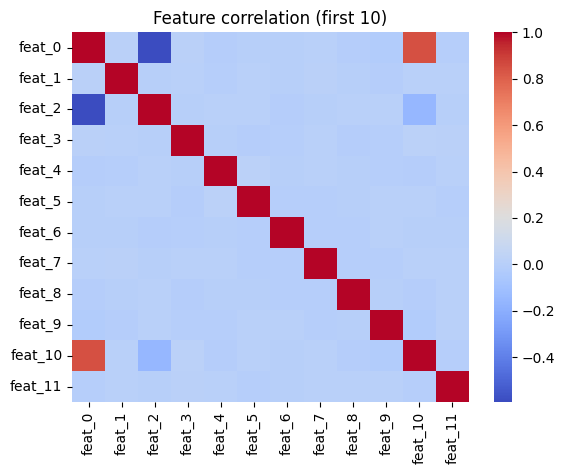

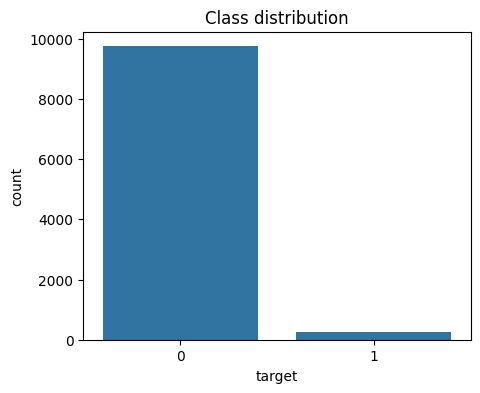

In [13]:
print("Class distribution:\n", df['target'].value_counts())
print("Ratio (major/minor):", df['target'].value_counts().iloc[0] / df['target'].value_counts().iloc[1])
display(df.describe().T)

# Correlation heatmap (first 12 features for readability)
sns.heatmap(df[cols[:12]].corr(), annot=False, cmap='coolwarm')
plt.title('Feature correlation (first 10)')
plt.show()

# Class distribution plot
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.title('Class distribution')
plt.show()

### A.2: Stratified split: train/val/test (70/15/15)


In [14]:
X = df[cols].values
y = df['target'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Improve the printing of class counts
split_counts = pd.DataFrame({
    'Train': Counter(y_train),
    'Val': Counter(y_val),
    'Test': Counter(y_test)
}).T

print("Class distribution after splitting:")
display(split_counts)

Class distribution after splitting:


,0,1
Train,6825,175
Val,1462,38
Test,1463,37


### A.3: Why accuracy is misleading

 Accuracy can be high by predicting the majority class and thus fails to capture minority detection performance. Prefer PR-AUC and F1-family metrics.

## Part B — Baselines

In [15]:
from typing import Dict, Any, Tuple

def fit_and_eval(model, X_tr, y_tr, X_te, y_te, threshold=0.5):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    runtime = time.time() - t0
    probs = model.predict_proba(X_te)[:,1]
    preds = (probs >= threshold).astype(int)

    metrics = {
        'roc_auc': roc_auc_score(y_te, probs),
        'pr_auc': average_precision_score(y_te, probs),
        'f1': f1_score(y_te, preds),
        'f2': fbeta_score(y_te, preds, beta=2),
        'balanced_acc': balanced_accuracy_score(y_te, preds),
        'brier': brier_score_loss(y_te, probs),
        'confusion_matrix': confusion_matrix(y_te, preds)
    }
    return metrics, probs, runtime


 LogisticRegression

 RandomForest


,roc_auc,pr_auc,f1,f2,balanced_acc,brier,runtime_s
LogisticRegression,0.758327,0.360421,0.347826,0.254777,0.607766,0.019028,0.02
RandomForest,0.72851,0.422558,0.311111,0.224359,0.594253,0.018084,10.24


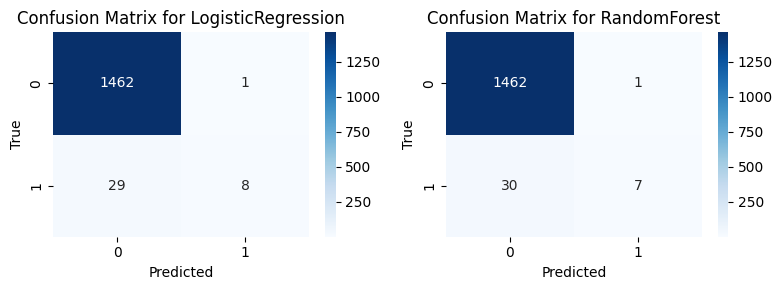

In [21]:
# Baseline models
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=2000, random_state=SEED))])
rf = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))])

baseline_results = {}
for name, model in [('LogisticRegression', lr), ('RandomForest', rf)]:
    print('\n', name)
    mets, probs, rt = fit_and_eval(model, X_train, y_train, X_test, y_test)
    baseline_results[name] = {k: v for k, v in mets.items() if k != 'confusion_matrix'}
    baseline_results[name]['confusion_matrix'] = mets['confusion_matrix']
    baseline_results[name]['runtime_s'] = round(rt, 2)

results_df = pd.DataFrame(baseline_results).T
display(results_df[['roc_auc', 'pr_auc', 'f1', 'f2', 'balanced_acc', 'brier', 'runtime_s']])

fig, axes = plt.subplots(1, len(results_df), figsize=(4 * len(results_df), 3))
if len(results_df) == 1:
    axes = [axes]
for i, (model_name, row) in enumerate(results_df.iterrows()):
    cm = row['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()

## Part C — Imbalance Mitigation Methods

### C.1: Define method pipelines

In [22]:
pipelines = {
    'none_rf': ImbPipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'smote_rf': ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=SEED)), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'adasyn_rf': ImbPipeline([('scaler', StandardScaler()), ('adasyn', ADASYN(random_state=SEED)), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'rus_rf': ImbPipeline([('scaler', StandardScaler()), ('rus', RandomUnderSampler(random_state=SEED)), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'smotetomek_rf': ImbPipeline([('scaler', StandardScaler()), ('smotetomek', SMOTETomek(random_state=SEED)), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'classweight_rf': ImbPipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED))]),
    'xgb_classweight': ImbPipeline([('scaler', StandardScaler()), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED, scale_pos_weight=(Counter(y_train)[0]/Counter(y_train)[1])) )])
}

### C.2: Fit and collect metrics + threshold tuning


In [27]:
results = {}
for i, (name, pipe) in enumerate(pipelines.items()):
    print(f'Training model {i+1}/{len(pipelines)}: {name}')
    t0 = time.time()
    pipe.fit(X_train, y_train)
    rt = time.time() - t0
    print(f'   Training finished in {rt:.2f} seconds.')
    probs_val = pipe.predict_proba(X_val)[:,1]
    prec, rec, th = precision_recall_curve(y_val, probs_val)
    f1_scores = 2*prec*rec/(prec+rec+1e-12)
    f2_scores = (1+2**2)*(prec*rec)/((2**2*prec)+rec+1e-12)
    best_f1_idx = f1_scores.argmax()
    best_f2_idx = f2_scores.argmax()
    best_f1_thresh = th[best_f1_idx] if best_f1_idx < len(th) else 0.5
    best_f2_thresh = th[best_f2_idx] if best_f2_idx < len(th) else 0.5

    # Evaluate on test with default and tuned thresholds
    mets_default, probs_test, rt2 = fit_and_eval(pipe, X_train, y_train, X_test, y_test, threshold=0.5)
    mets_f1, _, _ = fit_and_eval(pipe, X_train, y_train, X_test, y_test, threshold=best_f1_thresh)
    mets_f2, _, _ = fit_and_eval(pipe, X_train, y_train, X_test, y_test, threshold=best_f2_thresh)


    results[name] = {
        'runtime_train_s': rt,
        'default': mets_default,
        'f1_tuned': (best_f1_thresh, mets_f1),
        'f2_tuned': (best_f2_thresh, mets_f2)
    }

Training model 1/7: none_rf
   Training finished in 10.18 seconds.
Training model 2/7: smote_rf
   Training finished in 18.25 seconds.
Training model 3/7: adasyn_rf
   Training finished in 17.80 seconds.
Training model 4/7: rus_rf
   Training finished in 0.51 seconds.
Training model 5/7: smotetomek_rf
   Training finished in 18.85 seconds.
Training model 6/7: classweight_rf
   Training finished in 6.52 seconds.
Training model 7/7: xgb_classweight
   Training finished in 0.38 seconds.


### C.3: Calibration (Top 3 models based on F1 Score)

Top 3 models based on F1 Score (F1 Tuned): ['xgb_classweight', 'smotetomek_rf', 'smote_rf']

Calibrating and plotting for: xgb_classweight


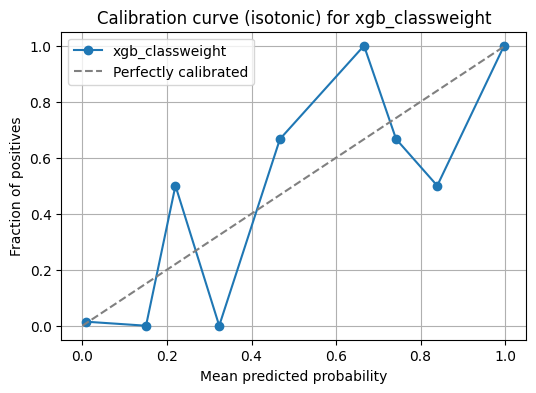


Calibrating and plotting for: smotetomek_rf


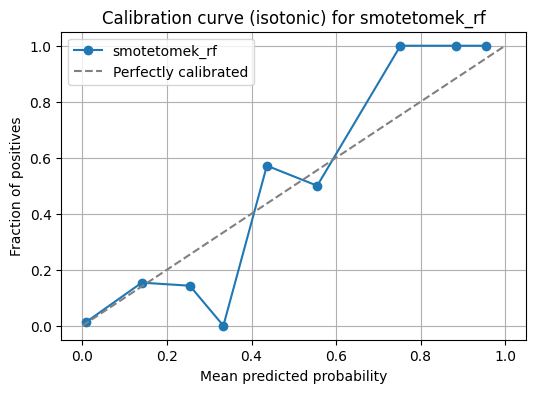


Calibrating and plotting for: smote_rf


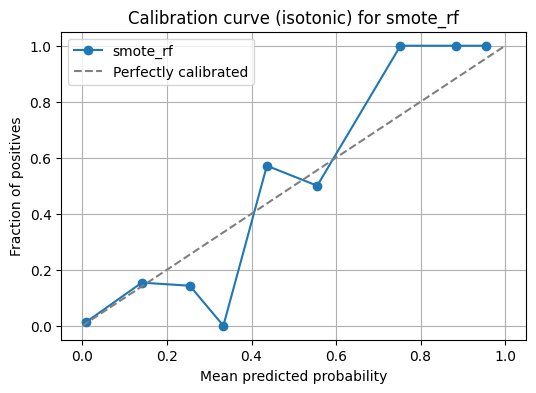

In [28]:
# Identify top 3 models based on F1 Score (F1 Tuned)
summary_df_tuned = summary_df[summary_df['Threshold Strategy'].str.contains('F1 Tuned')]
top_models_f1 = summary_df_tuned.sort_values(by='F1 Score', ascending=False).head(3)['Model'].tolist()

print("Top 3 models based on F1 Score (F1 Tuned):", top_models_f1)

for model_name in top_models_f1:
    print(f'\nCalibrating and plotting for: {model_name}')
    best_pipe = pipelines[model_name]
    calibrated_pipe = CalibratedClassifierCV(best_pipe, method='isotonic', cv=5)
    calibrated_pipe.fit(X_train, y_train)
    probs_calibrated = calibrated_pipe.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, probs_calibrated, n_bins=10)
    plt.figure(figsize=(6, 4))
    plt.plot(prob_pred, prob_true, 'o-', label=model_name)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfectly calibrated')
    plt.title(f'Calibration curve (isotonic) for {model_name}')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.grid(True)
    plt.show()

## Part D — Robust Evaluation (Stratified CV, CIs, Ablation)

### D.1: Cross-validated OOF PR-AUC and F1 with StratifiedKFold

In [30]:
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=SEED)

def cv_scores(pipe):
    pr_scores = []
    f1_scores = []
    runtimes = []
    for train_idx, test_idx in cv.split(X, y):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        t0 = time.time()
        pipe.fit(X_tr, y_tr)
        runtimes.append(time.time()-t0)
        probs = pipe.predict_proba(X_te)[:,1]
        pr_scores.append(average_precision_score(y_te, probs))
        preds = (probs >= 0.5).astype(int)
        f1_scores.append(f1_score(y_te, preds))
    return np.array(pr_scores), np.array(f1_scores), np.array(runtimes)

pr, f1s, rts = cv_scores(pipelines['smote_rf'])
print(f'PR-AUC mean ± 95% CI: {pr.mean():.4f} ± {1.96*pr.std()/np.sqrt(len(pr)):.4f}')
print(f'F1 mean ± 95% CI: {f1s.mean():.4f} ± {1.96*f1s.std()/np.sqrt(len(f1s)):.4f}')

PR-AUC mean ± 95% CI: 0.5706 ± 0.0306
F1 mean ± 95% CI: 0.5587 ± 0.0342


### D.2: Ablation study

In [31]:
ablation_results = {}
# Define variants: full, no_resample, no_threshold_tuning (we simulate by skipping tuning), no_calibration
variants = {
    'full_smote_rf': pipelines['smote_rf'],
    'no_resample_rf': ImbPipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))]),
    'classweight_rf': pipelines['classweight_rf']
}

for name, pipe in variants.items():
    pr, f1s, _ = cv_scores(pipe)
    ablation_results[name] = (pr.mean(), 1.96*pr.std()/np.sqrt(len(pr)), f1s.mean(), 1.96*f1s.std()/np.sqrt(len(f1s)))

pd.DataFrame(ablation_results, index=['PR_mean','PR_CI','F1_mean','F1_CI']).T

,PR_mean,PR_CI,F1_mean,F1_CI
full_smote_rf,0.570637,0.030610,0.558731,0.034241
no_resample_rf,0.614691,0.049203,0.469043,0.050836
classweight_rf,0.644577,0.042843,0.357188,0.038265


## Reporting & Saving Results

In [32]:
joblib.dump(results, 'results_summary.joblib')
for name, pipe in pipelines.items():
    joblib.dump(pipe, f'model_{name}.joblib')
print('Saved results and models')

Saved results and models
